In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date
from scipy.stats import norm 
import os

# Custom Libraries -->

import importlib
import src

importlib.reload(src.option)
importlib.reload(src.portfolio)
importlib.reload(src.simulation)
importlib.reload(src.tradier)

from src.option import OptionContract
from src.portfolio import Portfolio
from src.simulation import MonteCarloSimulation
from src.tradier import Tradier

In [19]:
%load_ext dotenv
%dotenv
access_token = os.environ.get("access_token")

SYMBOL = "TSLA"
START_DATE = "2023-01-01"
END_DATE = "2023-12-30"

tradier = Tradier(access_token)

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [20]:
daily_std = tradier.getVolatility(SYMBOL, START_DATE, END_DATE)
print("Daily STD:", daily_std)

Daily STD: 2.6713225951779003


In [21]:
expiration_dates = tradier.getSymbolExpirationDates(SYMBOL)
print("Expiration Dates:", expiration_dates)

expiration = expiration_dates[8]
today = date.today()
NUM_OF_DAYS = np.busday_count(today, expiration)

Expiration Dates: ['2024-01-12', '2024-01-19', '2024-01-26', '2024-02-02', '2024-02-09', '2024-02-16', '2024-02-23', '2024-03-15', '2024-04-19', '2024-05-17', '2024-06-21', '2024-07-19', '2024-09-20', '2025-01-17', '2025-06-20', '2025-09-19', '2025-12-19', '2026-01-16', '2026-06-18']


In [22]:
json_response = tradier.getOptionChain(SYMBOL, expiration)

call_strikes = [entry['strike'] if entry['option_type'] == "call" else None for entry in json_response['options']['option']]
call_bids = [entry['ask'] if entry['option_type'] == "call" else None for entry in json_response['options']['option']]
call_asks = [entry['bid'] if entry['option_type'] == "call" else None for entry in json_response['options']['option']]

put_strikes = [entry['strike'] if entry['option_type'] == "put" else None for entry in json_response['options']['option']]
put_bids = [entry['bid'] if entry['option_type'] == "put" else None for entry in json_response['options']['option']]
put_asks = [entry['ask'] if entry['option_type'] == "put" else None for entry in json_response['options']['option']]

In [23]:
price = tradier.getMarketPrice(SYMBOL)
print("Price:", price)

Price: 239.15


Adjusted Standard Deviation: 22.979585856920732
Call ATM:  240.0 Put ATM:  240.0 OTM:  265.0
Cost per trade:  61.400000000000006
Intersection: $ 227.2112424292378


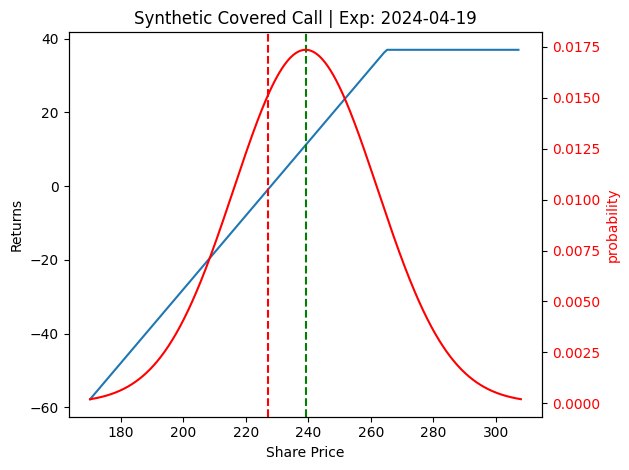

In [24]:
std = daily_std * np.sqrt(NUM_OF_DAYS)
print("Adjusted Standard Deviation:", std)

STD_WIDTH = 3
prices = np.arange(price - STD_WIDTH * std, price + STD_WIDTH * std, 1)

def getStrikeNearPrice(strikes: list, price: float):
    for i in range(len(strikes)):
        if strikes[i] != None and strikes[i] > price:
            return strikes[i], i

C_ATM_STRIKE, CALL_ATM_INDEX = getStrikeNearPrice(call_strikes, price)
C_ATM_PREMIUM = call_asks[CALL_ATM_INDEX]

P_ATM_STRIKE, PUT_ATM_INDEX = getStrikeNearPrice(put_strikes, price)
P_ATM_PREMIUM = put_bids[PUT_ATM_INDEX]

C_OTM_STRIKE, CALL_OTM_INDEX = getStrikeNearPrice(call_strikes, price + std)
C_OTM_PREMIUM = call_bids[CALL_OTM_INDEX]

print("Call ATM: ", C_ATM_STRIKE, "Put ATM: ", P_ATM_STRIKE, "OTM: ", C_OTM_STRIKE)

covered_call_strat = Portfolio([
    # ATM LONG CALL
    OptionContract(C_ATM_STRIKE, C_ATM_PREMIUM, 'Call', 'Long'),
    
    # ATM SHORT PUT
    OptionContract(P_ATM_STRIKE, P_ATM_PREMIUM, 'Put', 'Short'),
    
    # OTM SHORT CALL
    OptionContract(C_OTM_STRIKE, C_OTM_PREMIUM, 'Call', 'Short'),
])

fig, ax1 = plt.subplots()
ax1.title.set_text("Synthetic Covered Call | Exp: " + expiration)

values = covered_call_strat.getPriceInformation(prices)

# Binary search to find 0 in values
notFound = True
intersection = 0

start = 0
end = len(values) - 1

while notFound:
    section = values[start:end]
    mid = len(section) // 2

    # print(start, end, mid, section[mid])
    # print(section)
    
    if section[mid] > 0:
        end -= mid
    
    elif section[mid] < 0:
        start += mid
    
    if(len(section) <= 1):
        intersection = start
        notFound = False

print("Intersection: $", prices[intersection])

ax1.plot(prices, values)
ax1.set_xlabel('Share Price')
ax1.set_ylabel('Returns', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.axvline(x=prices[intersection], color='r', linestyle='--')
ax1.axvline(x=price, color='g', linestyle='--')

ax2 = ax1.twinx()

x_axis = np.arange(price-STD_WIDTH*std, price+STD_WIDTH*std, 0.1) 

ax2.plot(x_axis, norm.pdf(x_axis, price, std), color='r')
ax2.set_ylabel('probability', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.show()

In [25]:
import plotly.graph_objects as go

# Optimal Allocation Optimization
STARTING_BALANCE = 100_000
NUM_TRIALS = 1

df = pd.DataFrame(columns=['Index', 'Option Allocation',
                  'Cash Allocation', 'Returns', 'Max Drawdown'])

sample_size = 1000

seed = np.random.randint(0, 1000)
print("Seed:", seed)
np.random.seed(seed)
option_allocations = np.random.uniform(0, 1, sample_size)
cash_allocations = [1 - x for x in option_allocations]

for i, (option_allocation, cash_allocation) in enumerate(zip(option_allocations, cash_allocations)):
    cash_allocation = 1 - option_allocation

    simulation = MonteCarloSimulation(covered_call_strat, NUM_TRIALS, NUM_OF_DAYS, price, daily_std, STARTING_BALANCE)

    (result, maxDrawdown) = simulation.run(
        cash_allocation, option_allocation, display=False)

    temp = pd.DataFrame({
        'Index': i,
        'Option Allocation': option_allocation,
        'Cash Allocation': cash_allocation,
        'Returns': result,
        'Max Drawdown': maxDrawdown,
    }, index=[0])

    df = pd.concat([df, temp])

# Risk Free Rate of Return
(result, maxDrawdown) = simulation.run(1, 0, display=False)
print("Risk Free Rate of Return: ", result)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df['Max Drawdown'],
    y=df['Returns'],
    mode='markers',
    marker=dict(
        color=df['Option Allocation'],
        colorscale='RdBu',
        size=7,
        colorbar=dict(title="Sharpe<br>Ratio")
    )
))
fig.update_layout(
    template="plotly_white",
    title="Monte Carlo Simulation of " + SYMBOL +
    " | " + str(NUM_TRIALS) + " Trials",
    xaxis_title="Max Drawdown",
    yaxis_title="Returns",
)
fig.update_layout(coloraxis_colorbar=dict(title="Option Allocation"))

Seed: 774
Risk Free Rate of Return:  1013.8
